In [71]:
from augur.utils import json_to_tree
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import itertools
import requests
import collections
import math

%matplotlib inline

In [2]:
#Download tree json
tree_url = "https://data.nextstrain.org/ncov_global.json"

tree_json = requests.get(tree_url).json()

#Put tree in Bio.Phylo format
tree = json_to_tree(tree_json)

Walking from root to tip, make list of substitutions that occur sequentially 

In [153]:
def get_parent(tree, child_clade):
    node_path = tree.get_path(child_clade)
    return node_path


all_paths = []
node_muts = {}

for node in tree.find_clades(terminal=True):
    node_path = get_parent(tree, node)
    node_names_path = [x.name for x in node_path]
    all_paths.append(node_names_path)
    
    for parent in node_path:
        if hasattr(parent, "branch_attrs") and "mutations" in parent.branch_attrs:
            if "S" in parent.branch_attrs["mutations"]:   
                node_muts[parent.name] = {'spike_muts': parent.branch_attrs["mutations"]["S"], 
                                          'num_date': parent.node_attrs['num_date']['value']}

nodes_w_muts = list(node_muts.keys())

#pare down all_paths to only include nodes with spike mutations
#and only include paths with at least 2 spike mutations since we care about pairs
all_paths_spikemutnodesonly = []
for path in all_paths:
    spikemutsonly_path = []
    for x in path:
        if x in nodes_w_muts:
            spikemutsonly_path+=[x]
    if len(spikemutsonly_path)>=1:
        all_paths_spikemutnodesonly.append(spikemutsonly_path)
    

#find all unique pairs of nodes that occur sequentially in phylogeny and have spike mutations
unique_node_pairs = []
for path in all_paths_spikemutnodesonly:
    ordered_pairwise_combos = itertools.combinations(path, 2)
    for pair in ordered_pairwise_combos:
        if pair not in unique_node_pairs:
            unique_node_pairs.append(pair)
            
#translate each pair from node names into mutations and time difference
#some node pairs will have several mutations
#make sure order of mutations is preserved
spike_mut_pairs = {}
spike_pos_pairs = {}
all_spike_pairs_list = []
all_spike_pos_pairs_list = []
all_time_diffs = []
count = 1
for pair in unique_node_pairs:
    time_diff = node_muts[pair[1]]['num_date'] - node_muts[pair[0]]['num_date']
    all_time_diffs.append(time_diff)
    mut_pairs_for_these_nodes = [(x,y) for x in node_muts[pair[0]]['spike_muts'] for y in node_muts[pair[1]]['spike_muts']]
    for y in mut_pairs_for_these_nodes:
        mut_pos = (y[0][1:-1], y[1][1:-1])
        spike_mut_pairs[count] = {'mut_pair': y, 'time_between_muts':time_diff}
        spike_pos_pairs[count] = {'mut_pair': mut_pos, 'time_between_muts':time_diff}
        all_spike_pairs_list.append(y)
        all_spike_pos_pairs_list.append(mut_pos)
        count+=1


Find distribution of times between pairs of mutations

(array([ 4.,  7., 19., 21., 27., 30., 28., 40., 35., 34., 41., 54., 58.,
        50., 70., 65., 52., 76., 67., 56., 55., 67., 60., 43., 50., 40.,
        46., 43., 41., 43., 42., 37., 45., 40., 59., 87., 93., 50., 58.,
        68., 71., 57., 74., 38., 43., 51., 37., 48., 26.,  5.]),
 array([0.01067507, 0.03317756, 0.05568006, 0.07818256, 0.10068505,
        0.12318755, 0.14569004, 0.16819254, 0.19069504, 0.21319753,
        0.23570003, 0.25820253, 0.28070502, 0.30320752, 0.32571001,
        0.34821251, 0.37071501, 0.3932175 , 0.41572   , 0.4382225 ,
        0.46072499, 0.48322749, 0.50572998, 0.52823248, 0.55073498,
        0.57323747, 0.59573997, 0.61824247, 0.64074496, 0.66324746,
        0.68574995, 0.70825245, 0.73075495, 0.75325744, 0.77575994,
        0.79826244, 0.82076493, 0.84326743, 0.86576993, 0.88827242,
        0.91077492, 0.93327741, 0.95577991, 0.97828241, 1.0007849 ,
        1.0232874 , 1.0457899 , 1.06829239, 1.09079489, 1.11329738,
        1.13579988]),
 <a list of 50

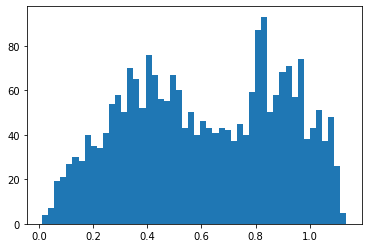

In [88]:
plt.hist(all_time_diffs, bins=50)

For each pair of mutations, find the average time between their occurence. Find which mutation pairs occur sequentially most rapidly

In [158]:
#only look at pairs that occur at least twice in tree
def average_time_between(mut_or_pos, occurences):
    if mut_or_pos == 'mut':
        pair_list = all_spike_pairs_list
        pair_dict = spike_mut_pairs
    elif mut_or_pos == 'pos':
        pair_list = all_spike_pos_pairs_list
        pair_dict = spike_pos_pairs
    all_observed_mut_combos = [k for k, v in collections.Counter(pair_list).items() if int(v)>=occurences]

    mean_time_between_muts = []

    for combo in all_observed_mut_combos:
        combo_time_diffs = []
        for k, v in pair_dict.items():
            if v['mut_pair'] == combo:
                combo_time_diffs.append(v['time_between_muts'])
        avg_time_diff = sum(combo_time_diffs)/len(combo_time_diffs)
        mean_time_between_muts.append({'mut_pair': combo, 'mean_time_diff':avg_time_diff, 
                                       'occurence_of_pair':len(combo_time_diffs)})

    mean_time_df = pd.DataFrame(mean_time_between_muts)
    
    print(mean_time_df.nsmallest(20, ['mean_time_diff']))

In [165]:
average_time_between('mut', 3)

            mut_pair  mean_time_diff  occurence_of_pair
182     (A570D, L5F)        0.255328                  3
183     (P681H, L5F)        0.255328                  3
184     (T716I, L5F)        0.255328                  3
185    (D1118H, L5F)        0.255328                  3
192   (A570D, A982S)        0.319007                  3
193   (P681H, A982S)        0.319007                  3
194   (T716I, A982S)        0.319007                  3
195  (D1118H, A982S)        0.319007                  3
157   (L242-, -243A)        0.319716                  3
160   (A243-, -243A)        0.319716                  3
153   (L241-, -241L)        0.352076                  3
155   (L242-, -241L)        0.352076                  3
158   (A243-, -241L)        0.352076                  3
161   (E484K, -241L)        0.352076                  3
125     (H69-, S98F)        0.357946                  3
126     (V70-, S98F)        0.357946                  3
156   (L242-, -242L)        0.363862            

Look for enrichment of cooccurence

In [ ]:
sequences_url = "https://data.nextstrain.org/ncov_global-sequences.json"

frequencies = requests.get(frequencies_url)